In [49]:
import os
import pandas as pd

feature_selected_data_dir = '../data/selected'
processed_data_dir = '../data/processed'
resampled_data_dir = '../data/resampled'

# Load selected features
X_train = pd.read_csv(os.path.join(resampled_data_dir,'X_train_res.csv'))
X_test = pd.read_csv(os.path.join(feature_selected_data_dir,'X_test_selected.csv'))

y_train = pd.read_csv(os.path.join(resampled_data_dir, 'y_train_res.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(processed_data_dir, 'y_test.csv')).values.ravel()

In [41]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

def objective(trial):
    # Define the search space for hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42,
        'eval_metric': 'logloss',
        'device': 'cuda',
        'n_jobs': -1
    }

    # Create and train the model with the suggested hyperparameters
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)

    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    mean_score = scores.mean()

    return mean_score

In [42]:
# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameters and the best score
print('Best Parameters:', study.best_params)
print('Best ROC AUC Score:', study.best_value)

[I 2025-02-05 20:39:27,101] A new study created in memory with name: no-name-1ab07777-0f60-4530-a84e-9b80c027e2c9
[I 2025-02-05 20:39:33,803] Trial 0 finished with value: 0.9999883555174586 and parameters: {'n_estimators': 487, 'max_depth': 5, 'learning_rate': 0.24070418703869695, 'subsample': 0.6181128328044412, 'colsample_bytree': 0.8992588492690836, 'gamma': 0.000363713261791761, 'min_child_weight': 3, 'reg_alpha': 0.0006362515530907115, 'reg_lambda': 5.733503632011744e-07}. Best is trial 0 with value: 0.9999883555174586.
[I 2025-02-05 20:39:38,881] Trial 1 finished with value: 0.999600399963751 and parameters: {'n_estimators': 246, 'max_depth': 6, 'learning_rate': 0.014304444083713392, 'subsample': 0.7324074525473574, 'colsample_bytree': 0.8003378432699214, 'gamma': 0.09307010565250218, 'min_child_weight': 5, 'reg_alpha': 0.027255673016215124, 'reg_lambda': 1.2608035834453136e-06}. Best is trial 0 with value: 0.9999883555174586.
[I 2025-02-05 20:39:44,099] Trial 2 finished with val

Best Parameters: {'n_estimators': 375, 'max_depth': 6, 'learning_rate': 0.17369367999169733, 'subsample': 0.8546848066212989, 'colsample_bytree': 0.8950730116446355, 'gamma': 1.1637522263226727e-07, 'min_child_weight': 1, 'reg_alpha': 0.2869749898165918, 'reg_lambda': 4.146706685327304e-07}
Best ROC AUC Score: 0.9999917479646628


In [43]:
# Train the final model with the best parameters
best_params = study.best_params
best_model = XGBClassifier(**best_params, random_state=42, device='cuda')
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

In [44]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.86      0.79        98

    accuracy                           1.00     56962
   macro avg       0.87      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962



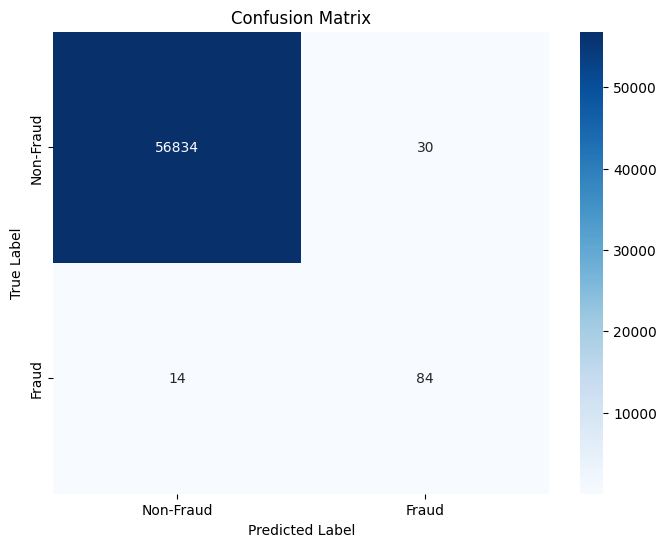

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [47]:
y_scores = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

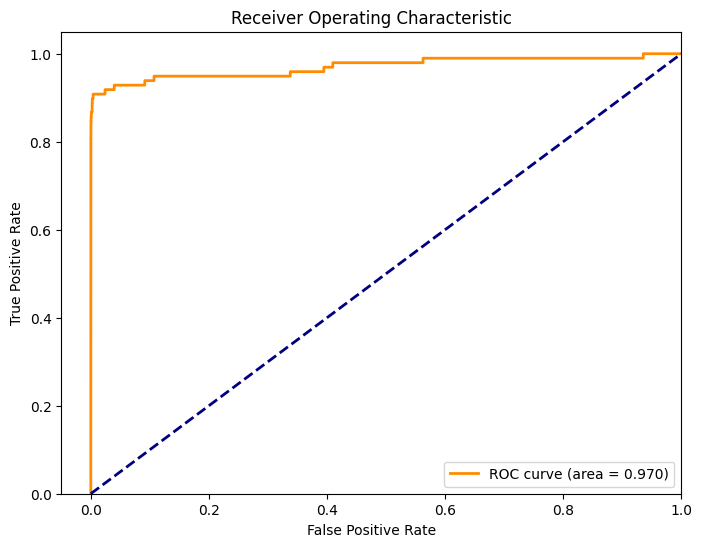

In [48]:
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()